In [ ]:
import asyncio
class Barrier:
    def __init__(self, target):
        self.counter = 0
        self.target = target
        self.lock = asyncio.Lock()
        self.round = 0
        self.done = 0

    async def wait(self, rank):
        while self.done > 0:
            await asyncio.sleep(0.01)
        round = self.round
        async with self.lock:
            self.counter += 1
        while self.counter < self.target:
            await asyncio.sleep(0.01)
        self.done += 1
        if rank == 0:
           await self.reset()

    async def reset(self):
        while self.done < self.target:
            await asyncio.sleep(0.01)
        self.counter = 0
        self.done = 0


class Dist:
    def __init__(self, total):
        self.reduce = None
        self.ranks = total
        self.barrier = Barrier(total)
        self.queue = [asyncio.Queue(maxsize=1) for i in range(total)]

    async def allreduce(self, rank, inp):
        if self.reduce is None:
            self.reduce = inp
        else:
            assert self.reduce.keys() == inp.keys()
            self.reduce = {k: self.reduce[k] + inp[k] for k in  inp}
        await self.barrier.wait(rank)
        q = self.reduce
        await self.barrier.wait(rank)
        if rank == 0:
            self.reduce = None
        await self.barrier.wait(rank)
        return q

    async def allgather(self, rank, inp):
        if self.reduce is None:
            self.reduce = inp
        else:
            self.reduce = self.reduce.combine(inp)
        await self.barrier.wait(rank)
        q = self.reduce
        await self.barrier.wait(rank)
        if rank == 0:
            self.reduce = None
        await self.barrier.wait(rank)
        return q

    async def scatterreduce(self, rank, inp):
        x = await self.allreduce(self, rank, inp)
        return x.shard(rank, self.ranks)

    async def receive(self, rank):
        return await self.queue[rank].get()

    async def pass_to(self, rank, v):
        await self.queue[rank].put(v)

# Test
async def say(rank, i, dist):
    q = await dist.allreduce(rank, {1:i})
    print(rank, q)
    q = await dist.allreduce(rank, {1:i+1})
    print(rank, q)
    if rank == 0:
        await dist.pass_to(1, 10)
    if rank == 1:
        print(rank, await dist.receive(rank))

    print(rank, q)

async def main():
    b = Dist(2)
    await asyncio.gather(say(0, 1, b),
                         say(1, 2, b))

await main()

1 {1: 3}
0 {1: 3}
1 {1: 5}
0 {1: 5}
0 {1: 5}
1 10
1 {1: 5}


In [ ]:
from dataclasses import dataclass
from typing import Tuple, List

LAYERS = 6
@dataclass
class OptState:
    layer: int
    step: int
    shards: Tuple[int] = (0,)
    total: int = 1

    def combine(self, other):
        return OptState(self.layer, self.step, self.shards + other.shards, self.total)

    def memory(self):
        return len(self.shards) / self.total

@dataclass
class Weight:
    layer: int
    step: int
    shards: Tuple[int] = (0,)
    total: int = 1

    def combine(self, other):
        return Weight(self.layer, self.step, self.shards + other.shards, self.total)

    def memory(self):
        return len(self.shards) / self.total

@dataclass
class Activation:
    layer: int
    batches: List[int]

    def memory(self):
        return len(self.batches)


@dataclass
class WeightGrad:
    layer: int
    batches: List[int]
    shards: Tuple[int] = (0,)
    total: int = 1

    def __add__(self, other):
        assert self.layer == other.layer, "Only add same layer weight grads"
        assert self.shards == other.shards
        return WeightGrad(self.layer, self.batches + other.batches, self.shards)

    def memory(self):
        return len(self.batches) * len(shard) / total

    def shard(self, shard, total):
        return WeightGrad(layer, batches, (shard,), total)


@dataclass
class LayerGrad:
    layer: int
    batches: List[int]

    def memory(self):
        return len(self.batches)


@dataclass
class Event:
    typ: str
    layer: int
    rank: int
    time: int
    memory: int
    batches: List[int] = 0

class Model:
    def __init__(self, rank: int, dist, layers: int, batches: int):
        self.rank = rank
        self.log = []
        self.dist = dist
        self.time = 0
        self.RANKS = dist.ranks
        self.LAYERS = layers
        self.BATCHES = batches
        self.weights = {}
        self.opt_states = {}
        self.activations = {}
        self.grad_activations = {}
        self.grad_weights = {}

    def memory(self):
        mem = 0
        for d in [self.weights, self.opt_states, self.activations, self.grad_activations, self.grad_weights]:
            for v in d.values():
                mem += v.memory()
        return mem

    def event(self, typ: str, layer, batches=0):
        self.log.append(Event(typ, layer, self.rank, self.time, self.memory(), batches))
        if typ != "loss":
            self.time += 1

    def load_weights(self, layers: List[int]) -> None:
        for layer in layers:
            self.weights[layer] = Weight(layer, 0)
            self.opt_states[layer] = OptState(layer, 0)

    def remove_weights(self, layers: List[int]) -> None:
        for layer in layers:
            del self.weights[layer]

    def get_activation(self, batches):
        return Activation(0, batches)

    def forward(self, layer: int, inp: Activation) -> Activation :
        self.event("forward", layer, inp.batches)
        weight = self.weights[layer]
        assert weight.layer == layer, f"Layer {layer}"
        assert inp.layer == layer
        return Activation(layer + 1, inp.batches)

    def backward(self, layer: int, inp: Activation, grad: LayerGrad) -> Tuple[WeightGrad, LayerGrad] :
        self.event("backward", layer, inp.batches)
        weight = self.weights[layer]
        assert weight.layer == layer
        assert inp.layer == layer
        assert set(inp.batches) == set(grad.batches), f"Batch mismatch {set(inp.batches)}"
        assert grad.layer == layer
        return (WeightGrad(layer, inp.batches), LayerGrad(layer - 1, inp.batches))

    def loss(self, inp: Activation) -> LayerGrad:
        self.event("loss", self.LAYERS)
        assert inp.layer == self.LAYERS
        return LayerGrad(self.LAYERS - 1, inp.batches)

    def update(self, layers: List[int], weight_grads) -> None:
        self.event("update", layers)
        new_weights = {}
        new_opts = {}
        for layer in layers:
            assert self.weights[layer].layer == layer
            assert weight_grads[layer].layer == layer
            assert set(weight_grads[layer].batches) == set(range(self.BATCHES)), \
                f"{set(weight_grads[layer].batches)}"
            assert self.opt_states[layer].layer == layer
            assert self.weights[layer].step == self.opt_states[layer].step
            new_opts[layer] = OptState(layer, self.opt_states[layer].step+1)
            new_weights[layer] = Weight(layer, self.weights[layer].step+1)
        self.opt_states = new_opts
        self.weights = new_weights


    async def allreduce(self, v):
        self.event("allreduce", None)
        return await self.dist.allreduce(self.rank, v)

    async def scatterreduce(self, v):
        self.event("scatterreduce", None)
        return await self.dist.scatterreduce(self.rank, v)

    async def allgather(self, v):
        self.event("allgather", None)
        return await self.dist.allgather(self.rank, v)

    async def pass_to(self, rank, v):
        return await self.dist.pass_to(rank, (v, self.time))

    async def receive(self):
        v, time = await self.dist.receive(self.rank)
        self.time = max(time, self.time)
        return v
    @staticmethod
    def check(models):
        weights = {k: v for m in models for k,v  in m.weights.items()}
        for l in range(models[0].LAYERS):
            assert weights[l].step == 1

async def problem1(model):
    model.activations[0] = model.get_activation(range(model.BATCHES))
    model.load_weights(range(model.LAYERS))

    # Forward
    for l in range(model.LAYERS):
        model.activations[l+1] = model.forward(l, model.activations[l])

    # Backward
    model.grad_activations[model.LAYERS] = model.loss(model.activations[model.LAYERS])

    for l in range(model.LAYERS-1, -1, -1):
        model.grad_weights[l], model.grad_activations[l] = model.backward(l, model.activations[l], model.grad_activations[l+1])
        del model.grad_activations[l+1], model.activations[l]

    # Update
    model.update(list(range(model.LAYERS)), model.grad_weights)

    return [model]
dist = Dist(1)
model1 = await problem1(Model(0, dist, layers=6, batches=2))
Model.check(model1)

In [ ]:
async def ddp(model):
    model.activations[0] = model.get_activation([model.rank])
    model.load_weights(range(model.LAYERS))

    # Forward
    for l in range(model.LAYERS):
        model.activations[l+1] = model.forward(l, model.activations[l])

    # Backward
    model.grad_activations[model.LAYERS] = model.loss(model.activations[model.LAYERS])

    for l in range(model.LAYERS-1, -1, -1):
        model.grad_weights[l], model.grad_activations[l] = model.backward(l, model.activations[l], model.grad_activations[l+1])
        del model.grad_activations[l+1], model.activations[l]

    # Update
    model.grad_weights = await model.allreduce(model.grad_weights)
    model.update(list(range(model.LAYERS)), model.grad_weights)

    return model

async def main():
    ranks = 2
    dist = Dist(ranks)
    return await asyncio.gather(*[ddp(Model(rank, dist, layers=6, batches=2))
                                  for rank in range(ranks)])

model2 = await main()

In [ ]:

async def pipeline(model):
    per_rank = model.LAYERS // model.RANKS
    my_layers = list([l + (model.rank * per_rank) for l in range(per_rank)])
    model.load_weights(my_layers)

    if model.rank == 0:
        model.activations[0] = model.get_activation(range(model.BATCHES))
    else:
        model.activations[my_layers[0]] = await model.receive()

    # Forward
    for l in my_layers:
        model.activations[l+1] = model.forward(l, model.activations[l])

    # Backward
    if model.rank == model.RANKS - 1:
        model.grad_activations[model.LAYERS] = model.loss(model.activations[model.LAYERS])
    else:
        await model.pass_to(model.rank + 1, model.activations[l + 1])
        model.grad_activations[l + 1] = await model.receive()

    for l in reversed(my_layers):
        model.grad_weights[l], model.grad_activations[l] = model.backward(l, model.activations[l], model.grad_activations[l+1])
        del model.grad_activations[l+1], model.activations[l]

    if model.rank != 0:
        await model.pass_to(model.rank - 1, model.grad_activations[l])

    # Update
    model.update(my_layers, model.grad_weights)
    return model

async def main():
    ranks = 4
    dist = Dist(ranks)
    return await asyncio.gather(*[pipeline(Model(rank, dist, layers=8, batches=2))
                                  for rank in range(ranks)])

model3 = await main()
Model.check(model3)

In [ ]:
async def gpipe(model):
    per_rank = model.LAYERS // model.RANKS
    my_layers = list([l + (model.rank * per_rank) for l in range(per_rank)])
    model.load_weights(my_layers)

    for mb in [0, 1]:
        # Forward
        if model.rank == 0:
            model.activations[0, mb] = model.get_activation([mb])
        else:
            model.activations[my_layers[0], mb] = await model.receive()

        for l in my_layers:
            model.activations[l+1, mb] = model.forward(l, model.activations[l, mb])
        if model.rank != model.RANKS - 1:
            await model.pass_to(model.rank + 1, model.activations[l + 1, mb])

    for mb in [0, 1]:
        # Backward
        if model.rank == model.RANKS - 1:
            model.grad_activations[model.LAYERS, mb] = model.loss(model.activations[model.LAYERS, mb])
        else:
            model.grad_activations[my_layers[-1] + 1, mb] = await model.receive()

        for l in reversed(my_layers):
            model.grad_weights[l, mb], model.grad_activations[l, mb] = \
                model.backward(l, model.activations[l, mb], model.grad_activations[l+1, mb])
            del model.grad_activations[l+1, mb], model.activations[l, mb]

        if model.rank != 0:
            await model.pass_to(model.rank - 1, model.grad_activations[l, mb])

    # Update
    for l in reversed(my_layers):
        model.grad_weights[l] = model.grad_weights[l, 0] + model.grad_weights[l, 1]
        del  model.grad_weights[l, 0], model.grad_weights[l, 1]
    model.update(my_layers, model.grad_weights)
    return model

async def main():
    ranks = 4
    dist = Dist(ranks)
    return await asyncio.gather(*[gpipe(Model(rank, dist, layers=8, batches=2))
                                  for rank in range(ranks)])

model4 = await main()
Model.check(model4)

In [ ]:
model2

[<__main__.Model at 0x7f86032aa110>, <__main__.Model at 0x7f86032a9c90>]

In [ ]:
!pip install git+https://github.com/chalk-diagrams/chalk/
! sudo apt-get install libcairo2-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/chalk-diagrams/chalk/ to /tmp/pip-req-build-ft56jpio
  Running command git clone --filter=blob:none --quiet https://github.com/chalk-diagrams/chalk/ /tmp/pip-req-build-ft56jpio
  Resolved https://github.com/chalk-diagrams/chalk/ to commit f4f4582b6d1fe572b28ef71ee2cf575ea862cdf0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/chalk-diagrams/planar to /tmp/pip-install-ttz330l_/planar_77acbec03fbf4f4faff994aed29578d5
  Running command git clone --filter=blob:none --quiet https://github.com/chalk-diagrams/planar /tmp/pip-install-ttz330l_/planar_77acbec03fbf4f4faff994aed29578d5
  Resolved https://github.com/chalk-diagrams/planar to commit 1e06d5894af31984323532092848d87a98278235
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

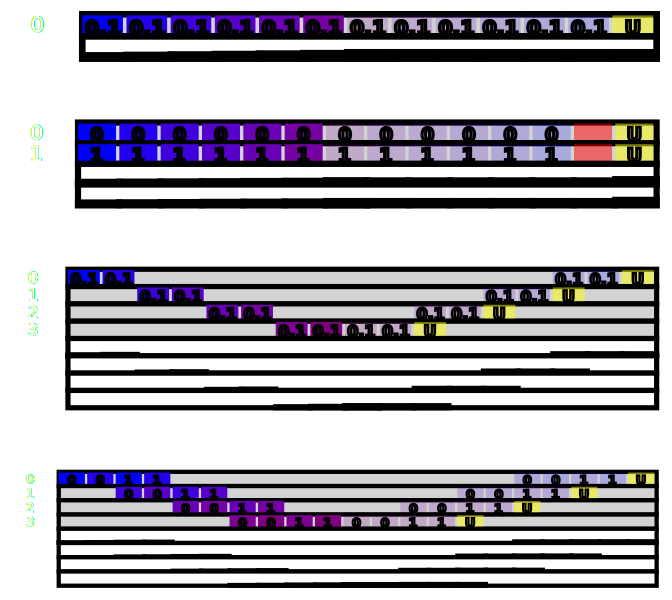

In [ ]:
from chalk import *
from colour import Color
forward_col = list(Color("Blue").range_to("Purple", 8))
# backward_col = list(Color("Yellow").range_to("Red", LAYERS))

def draw(models):
    TIME = 2
    def square(layer,time, s=""):
        PAD = 0.2
        return (rectangle(TIME*0.92, 0.9).line_width(0) + text(s, 0.9).translate(0, 0.1).line_width(0.05).fill_color(Color("black"))).align_l().translate(time * TIME, 0)

    def draw_forward(e):
        return square(e.layer, e.time, ",".join(map(str, e.batches))).fill_color(forward_col[e.layer])
    def draw_backward(e):
        return square(e.layer, e.time, ",".join(map(str, e.batches))).fill_color(forward_col[e.layer]).fill_opacity(0.2)
    def draw_update(layer, time):
        return square(layer, time, "U").fill_color(Color("yellow")).fill_opacity(0.5)
    def draw_allred(layer, time):
        return square(layer, time).fill_color(Color("red")).fill_opacity(0.5)
    rows = []

    MAXTIME = max(m.log[-1].time for m in models)

    # Time
    for gpu in range(len(models)):
        d = empty()
        box = rectangle(TIME * (MAXTIME + 1),1).fill_color(Color("lightgrey")).align_l()
        box = box + text(str(gpu), 1).line_width(0).with_envelope(rectangle(TIME, 1)).translate(-TIME, 0)
        d += box
        for e in models[gpu].log:
            if e.typ == "forward":
                d += draw_forward(e)
            if e.typ == "backward":
                d += draw_backward(e)
            if e.typ == "update":
                d += draw_update(e.layer, e.time)
            if e.typ == "allreduce":
                d += draw_allred(e.layer, e.time)
        rows.append(d)
    d = vcat(rows)

    rows = []
    for gpu in range(len(models)):
        row = rectangle(TIME * (MAXTIME + 1),1).fill_color(Color("white")).align_l()

        for e in models[gpu].log:
            can = rectangle(TIME, e.memory / 100.0).align_b().align_l().fill_color(Color("black"))
            row = row.align_b() + can.translate(TIME * e.time, 0)
        rows.append(row)
    d2 = vcat(rows)
    d = vcat([d, d2])
    #return rectangle(1.5, 0.5) + d.scale_uniform_to_x(1).center_xy()
    return d.scale_uniform_to_x(1).center_xy()
set_svg_height(600)
set_svg_draw_height(100)

vcat([draw(model1), draw(model2), draw(model3), draw(model4)], 0.1)

In [ ]:
model2[1].log

[Event(typ='forward', layer=0, rank=1, time=0, memory=13, batches=0),
 Event(typ='forward', layer=1, rank=1, time=1, memory=14, batches=0),
 Event(typ='forward', layer=2, rank=1, time=2, memory=15, batches=0),
 Event(typ='forward', layer=3, rank=1, time=3, memory=16, batches=0),
 Event(typ='forward', layer=4, rank=1, time=4, memory=17, batches=0),
 Event(typ='forward', layer=5, rank=1, time=5, memory=18, batches=0),
 Event(typ='loss', layer=6, rank=1, time=6, memory=19, batches=0),
 Event(typ='backward', layer=5, rank=1, time=6, memory=20, batches=0),
 Event(typ='backward', layer=4, rank=1, time=7, memory=20, batches=0),
 Event(typ='backward', layer=3, rank=1, time=8, memory=20, batches=0),
 Event(typ='backward', layer=2, rank=1, time=9, memory=20, batches=0),
 Event(typ='backward', layer=1, rank=1, time=10, memory=20, batches=0),
 Event(typ='backward', layer=0, rank=1, time=11, memory=20, batches=0),
 Event(typ='allreduce', layer=None, rank=1, time=12, memory=20, batches=0),
 Event(ty